# Предсказание оттока сотрудников. МО

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании.

***Цель***

Предсказать отток сотрудников компании с учетом уровня удовлетворенности сотрудника.

***Задачи***


1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

***Описание данных***

От компании получены таблицы, содержащие следующие данные о работниках компании:

* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании;
* `quit` — увольнение сотрудника из компании.

## Установка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from scipy import stats as st

# загружаем библиотеки для визуализации 
import seaborn as sns

# загружаем библиотеку для проверки на мультиколлинеарность признаков
import phik
from phik.report import plot_correlation_matrix

# загружаем модули sklearn
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

# загружаем нужные модели МО
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [2]:
RANDOM_STATE = 42

plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 13
plt.rcParams['figure.figsize'] = (13,4)

# загружаем shap для интерпретации
shap.initjs()

In [3]:
def calculate_smape(actual: np.array, predicted: np.array) -> float:
    '''
    Calculate Symmetric Mean Absolute Percentage Error
    '''
    if type(actual) == pd.core.frame.DataFrame:
        actual = actual.job_satisfaction_rate.squeeze()
    elif type(predicted) == pd.core.frame.DataFrame:
        predicted = actual.job_satisfaction_rate.squeeze()
    else:
        pass
    SMAPE = 100 / len(actual) * (np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))/2)).sum()
    return SMAPE

In [4]:
# Функция для удаления префиксов
def remove_prefixes(name):
    '''
    Remove 'ohe__', 'ord__', 'num__' prefixes in string
    ---------------------------------------------------
    Return updated string
    '''
    prefixes_to_remove = ['ohe__', 'ord__', 'num__']
    for prefix in prefixes_to_remove:
        name = name.replace(prefix, '')
    return name

---
---

## Предсказаниие уровеня удовлетворённости сотрудника

### Загрузка данных

In [5]:
# пути для первого файла
pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth1_1 = 'https://example.ru/train_job_satisfaction_rate.csv'
# пути для второго файла
pth2 = '/datasets/test_features.csv'
pth2_1 = 'https://example.ru/test_features.csv'
# пути для третьего файла
pth3 = '/datasets/test_target_job_satisfaction_rate.csv'
pth3_1 = 'https://example.ru/test_target_job_satisfaction_rate.csv'

# список локальных путей
local_pth = [pth1, pth2, pth3]
# список серверных путей
server_pth = [pth1_1, pth2_1, pth3_1]

# пустые датафреймы
df_train_jsr = pd.DataFrame
df_test_features_jsr = pd.DataFrame
df_test_target_jsr = pd.DataFrame

datas = [df_train_jsr, df_test_features_jsr, df_test_target_jsr]

In [6]:
for i, el in enumerate(datas):
    try:
        datas[i] = pd.read_csv(local_pth[i], index_col='id')
    except:
        datas[i] = pd.read_csv(server_pth[i], index_col='id')

In [7]:
# выведем первые строки таблиц
for el in datas:
    display(el.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


In [8]:
df_train_jsr = datas[0].sort_index()
df_test_features_jsr = datas[1].sort_index()
df_test_target_jsr = datas[2].sort_index()

---

### Предобработка данных

#### train_jsr

In [9]:
# проверим наличие явных дубликатов
f'Явных дубликатов: {df_train_jsr.duplicated().sum()}'

'Явных дубликатов: 245'

In [10]:
df_train_jsr.drop_duplicates(inplace=True)

In [11]:
# выведем информацию по таблице
df_train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 100954 to 999521
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


Проверим колонки с типом данных `object`.

In [12]:
# для каждой колонки выведем название и уникальные значения
for col in list(df_train_jsr.select_dtypes(include='object').columns):
    print(col, df_train_jsr[col].unique())
    print()

dept ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]

level ['junior' 'middle' 'sinior' nan]

workload ['low' 'medium' 'high']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']



В данных нет неявных дубликатов.

In [13]:
df_train_jsr.level.replace('sinior', 'senior', inplace=True)

In [14]:
# изменит типа данных на "category"
for col in list(df_train_jsr.select_dtypes(include='object').columns):
    df_train_jsr[col] = df_train_jsr[col].astype('category')

#### test_features_jsr

In [15]:
# выведем информацию о датафрейме
df_test_features_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [16]:
# для каждой колонки выведем название и уникальные значения
for col in list(df_test_features_jsr.select_dtypes(include='object').columns):
    print(col, df_test_features_jsr[col].unique())
    print()

dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']

level ['junior' 'middle' 'sinior' nan]

workload ['low' 'high' 'medium' ' ']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']



In [17]:
# исправим синтаксическую ошибку и уберем неизвестное строковое значение
df_test_features_jsr.replace({'sinior': 'senior', ' ': np.nan}, inplace=True)

df_test_features_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


#### df_test_target_jsr

In [18]:
# выведем информацию о таблице
df_test_target_jsr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


#### Проверка выборок на пересечение данных в выборках

In [19]:
# проверим на пересечение данных тренировочную и тестовую выборки
count=0
for el in df_test_features_jsr.index: 
    count += int(el in df_train_jsr.index)
f'Кол-во пересечений данных тренировочных и тестовых данных: {count}'

'Кол-во пересечений данных тренировочных и тестовых данных: 0'

#### Выводы
1. Были удалены явные дубликаты в тренировочных данных.


2. В датафреймах с тренировочными и тестовыми выборками обнаружены пропуски данных в колонках с уровнем занимаемой должности в компании и отделом, в котором работает сотрудник.


3. В датафреймах `df_test_target_jsr` и `df_test_features_jsr` соответствуют идентификаторы сотрудников.


4. Данные тренировочной и тестовой выборок не прересекаются.

---

### Исследовательский анализ данных

#### Количественные данные

In [20]:
# выведем статистику количественных данных тренировочной выборки
df_train_jsr.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


* В датафреймах содержатся данные о сотрудниках, которые устроены в компании от 1 года до 10 лет включительно. В среднем сотрудники работают в компании 3.8 лет.


* Качество работы сотрудников оценивается по пятибальной шкале. Средняя оценка качества работы - 3.5.


* Половина работников компании зарабатывает до 31.2 тыс.руб. Средняя заработная плата составляет 34 457.4 рубля.


* Половина работников оценивают свою удоовлетворенность работой в компании 0.55 баллами, а средний показатель удовлетворенности сотрудников 0.53.

In [21]:
# выведем статистику количественных данных тестовой выборки
df_test_features_jsr.join(df_test_target_jsr).agg(['mean', 'median'])

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
mean,3.6665,3.5265,34066.8,0.54878
median,3.0000,4.0000,30000.0,0.58000


Показатели количественных характеристик близки к значениям тренировочной выборки. Проблем во время тренировки не должно возникунуть.

В данных имеются 4 количественных характеристики: 2 из них дискретные (`employment_years`, `supervisor_evaluation`), две другие непрерывные (`salary`, `job_satisfaction_rate`).

In [22]:
# список дискретных колонок
discrete_cols = ['employment_years', 'supervisor_evaluation']
# список непрерывных колонок
interval_cols = ['salary', 'job_satisfaction_rate']
# список категориальных колонок
categorial_cols = list(df_train_jsr.select_dtypes(include='category').columns)

1. Рассмотрим графики распределения дискретных характеристик.

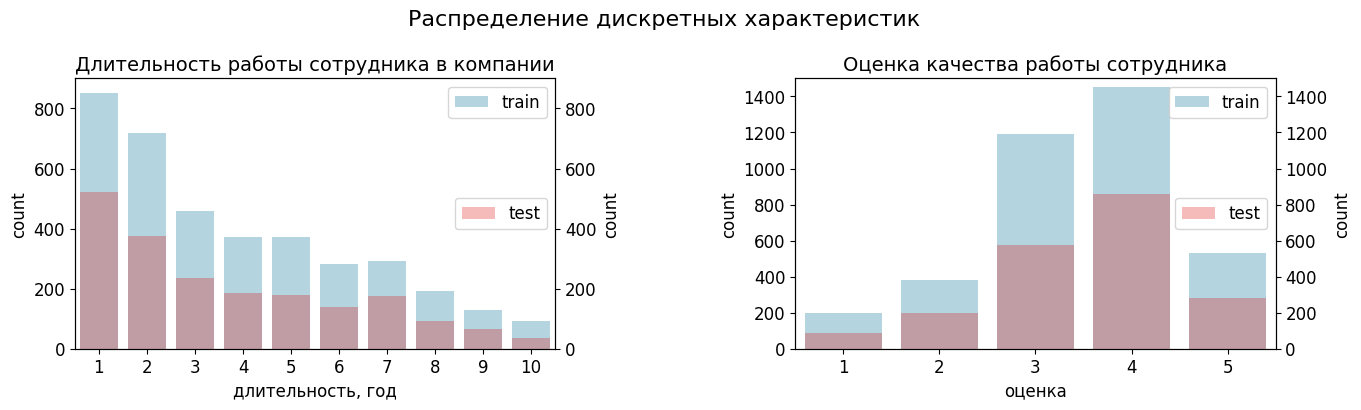

In [23]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Распределение дискретных характеристик')
fig.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=.5, hspace=0.5)
axs = [ax[0].twinx(), ax[1].twinx()]

for i, col in enumerate(discrete_cols):
    sns.countplot(data=df_train_jsr, x=col, ax=ax[i], color='lightblue', label='train')
    sns.countplot(data=df_test_features_jsr, x=col, ax=axs[i], color='red', alpha=0.3, label='test')
    ax[i].legend(loc='upper right')
    axs[i].legend(loc='center right')
ax[0].set_title('Длительность работы сотрудника в компании')
ax[0].set_xlabel('длительность, год')
ax[1].set_title('Оценка качества работы сотрудника')
ax[1].set_xlabel('оценка')

ax[0].set_ylim(0, 900)
axs[0].set_ylim(0, 900)
ax[1].set_ylim(0, 1500)
axs[1].set_ylim(0, 1500)
plt.show()

* Распределение длительности работы в компании имеет вид распределения Пуассона(?): чем больше срок работы в компании, тем меньше сотрудников соответствует этому условию.


* Распределение оценки качества сотрудников также имеет вид распределения Пуассона: большая часть сотрудников оценены в 3 и 4 балла.


Распределения характеристик тренировочной выборки подобны распределениям характеристик тренировочной выборки.

2. Рассмотрим графики распределения непрерывных характеристик.

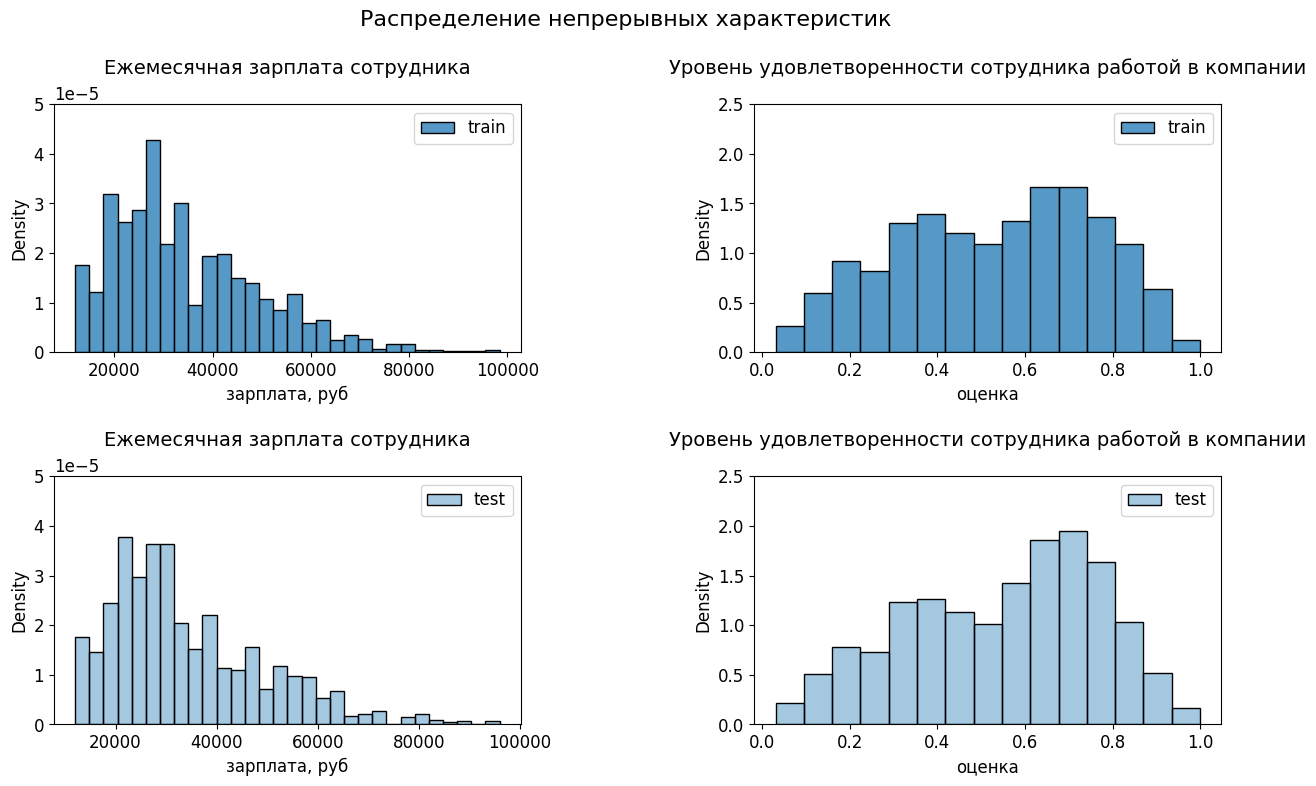

In [24]:
fig, ax = plt.subplots(2,2, figsize=(13,8))
fig.suptitle('Распределение непрерывных характеристик')
fig.tight_layout(pad=2.5)
plt.subplots_adjust(wspace=.5, hspace=.5)
bins = [30,15]
for i,col in enumerate(interval_cols):
    sns.histplot(data=df_train_jsr, x=col, bins=bins[i], stat='density', ax=ax[0,i])
    sns.histplot(data=df_test_features_jsr.join(df_test_target_jsr),
                 x=col, bins=bins[i], stat='density', alpha=0.4, ax=ax[1,i])
    ax[i,0].set_title('Ежемесячная зарплата сотрудника\n')
    ax[i,0].set_xlabel('зарплата, руб')
    ax[0,i].legend(['train'])
    ax[1,i].legend(['test'])
    ax[i,1].set_title('Уровень удовлетворенности сотрудника работой в компании\n')
    ax[i,1].set_xlabel('оценка')
    ax[i,0].set_ylim(0, 5e-5)
    ax[i,1].set_ylim(0, 2.5)
plt.show()

* Распределение работников компании по уровню заработной платы имеет правый хвост - работников, чья заработная платно выбивается из общей массы.


Распределения тестовой и тренировочной выборки схожи.

3. Рассмотрим распределение зарплаты сотрудников по уровню занимаемой должности.

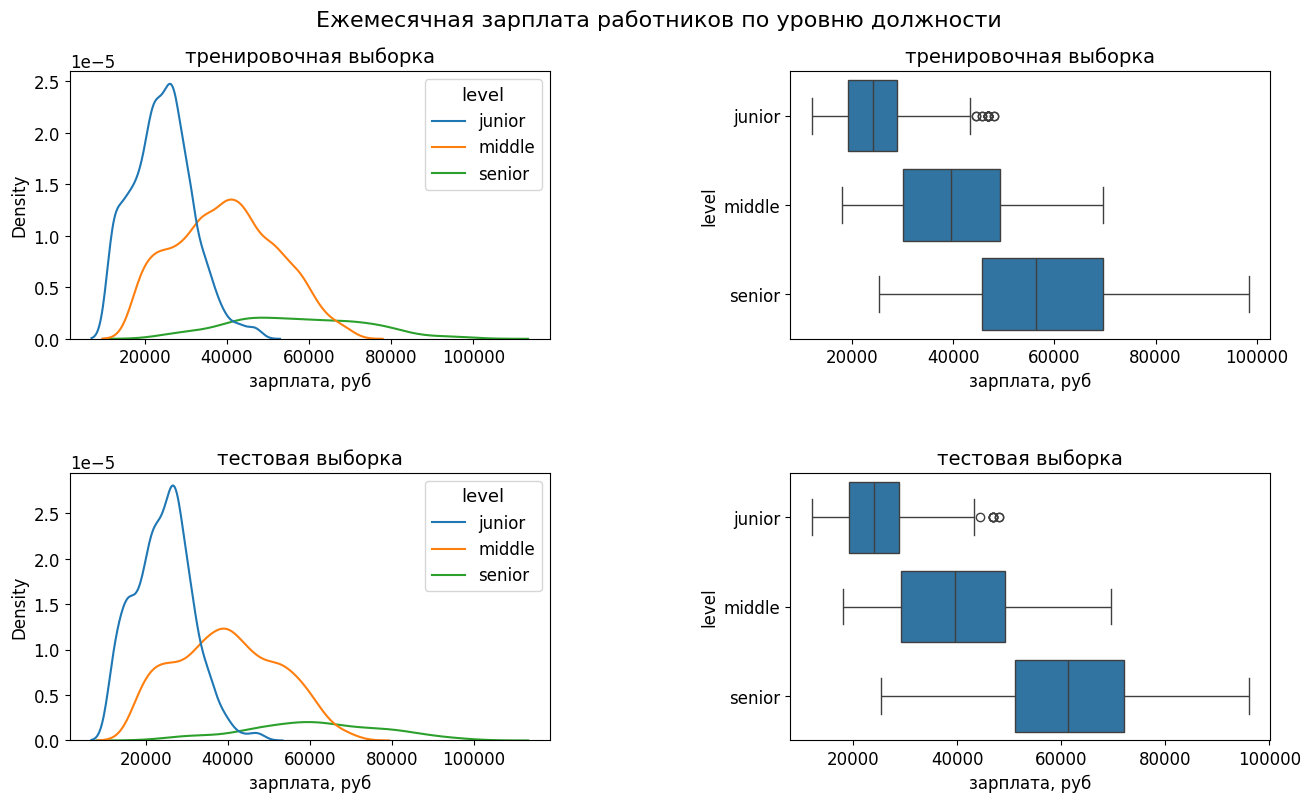

In [25]:
fig, ax = plt.subplots(2,2, figsize=(13,8))
fig.suptitle('Ежемесячная зарплата работников по уровню должности')
fig.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=.5, hspace=.5)
sns.kdeplot(data=df_train_jsr, x='salary', ax=ax[0,0], hue='level')
sns.boxplot(data=df_train_jsr, x='salary', ax=ax[0,1], y='level')
ax[0,0].set_xlabel('зарплата, руб')
ax[0,1].set_xlabel('зарплата, руб')
ax[0,0].set_title('тренировочная выборка')
ax[0,1].set_title('тренировочная выборка')

sns.kdeplot(data=df_test_features_jsr, x='salary', ax=ax[1,0], hue='level')
sns.boxplot(data=df_test_features_jsr, x='salary', ax=ax[1,1], y='level')
ax[1,0].set_xlabel('зарплата, руб')
ax[1,1].set_xlabel('зарплата, руб')
ax[1,0].set_title('тестовая выборка')
ax[1,1].set_title('тестовая выборка');

* Зарплатная вилка сотрудников сильно разнится в зависимости от уровня занимаемой дожности в компании.


* Так, логично, новички зарабатывают меньше всех (самая узкая зарплатная вилка), а сеньоры - больше всех (самая широкая з/п вилка). Все выбивающиеся значения з/п входят в нормальные значения для сеньоров.


Распределения тренировочной и тестовой выборох схожи.

#### Категориальные данные

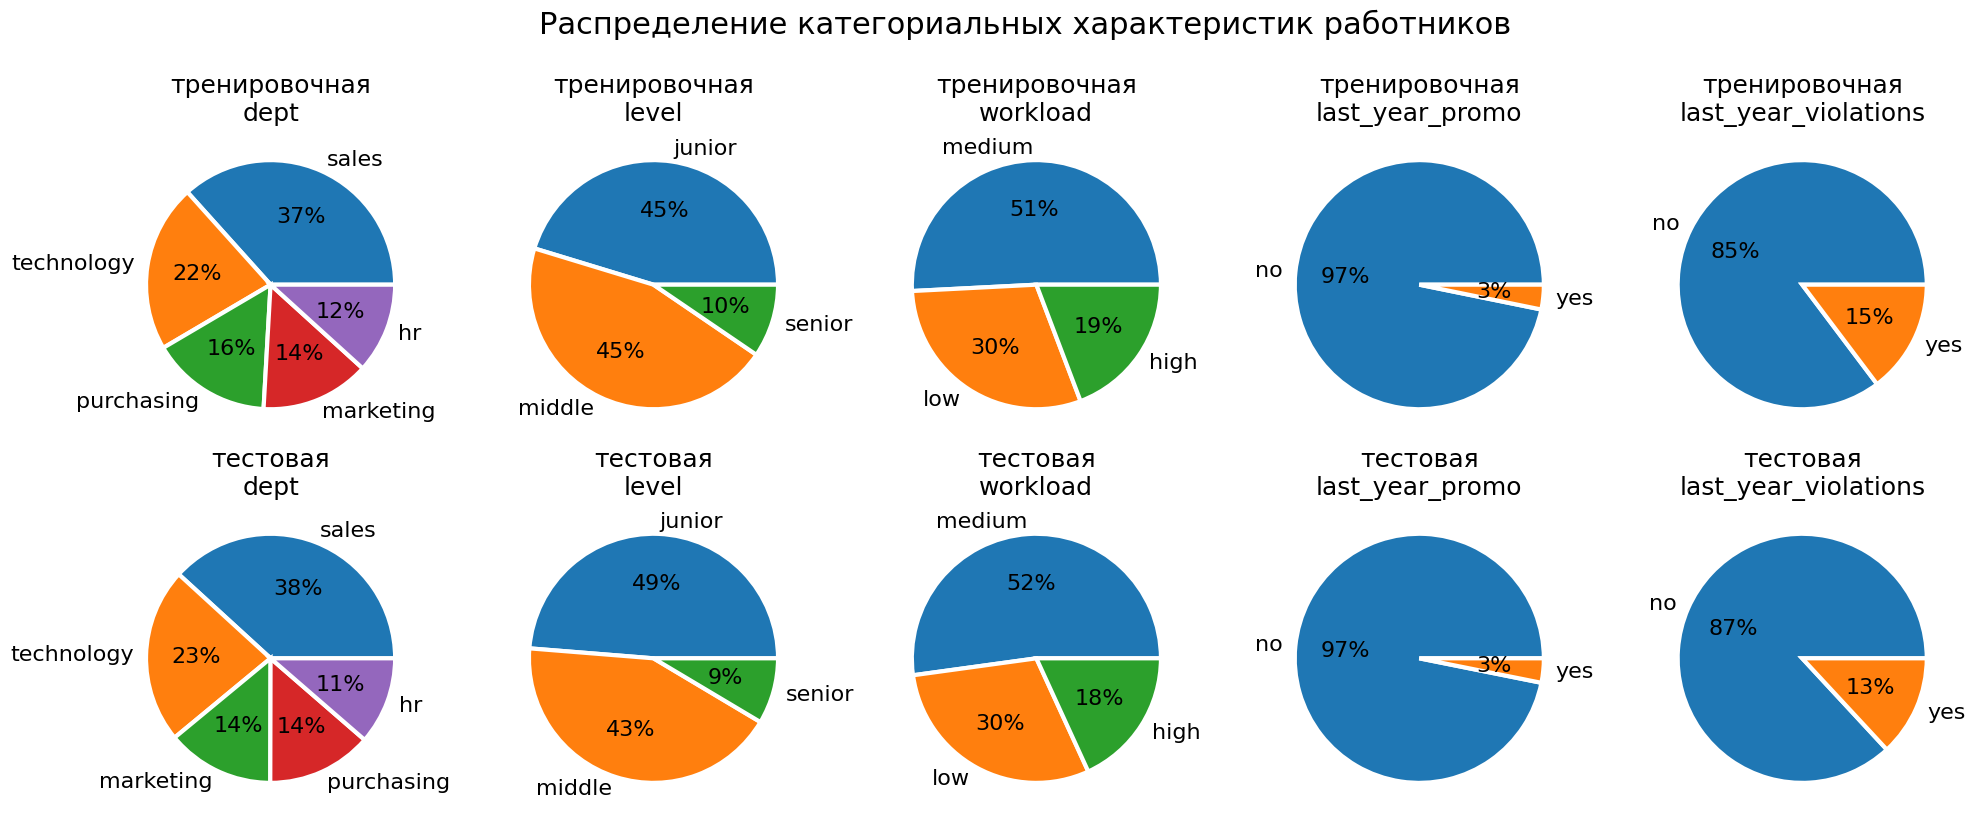

In [26]:
fig, ax = plt.subplots(ncols=len(categorial_cols), nrows=2, figsize=(20,9))
fig.suptitle(f'Распределение категориальных характеристик работников', fontsize=22)
fig.tight_layout(pad=3)
plt.subplots_adjust(wspace=.2, hspace=.2)
for i, col in enumerate(categorial_cols):
    l = df_train_jsr[col].value_counts().index
    s = df_train_jsr[col].value_counts()
#     пирог
    ax[0,i].pie(s, labels=l,
                autopct='%1.0f%%',
                textprops={'fontsize':16},
                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                pctdistance=.6, labeldistance=1.1)
    ax[0,i].set_title('тренировочная\n' + col, fontsize=18)
        
    l1 = df_test_features_jsr[col].value_counts().index
    s1 = df_test_features_jsr[col].value_counts()
#     пирог
    ax[1,i].pie(s1, labels=l1,
                autopct='%1.0f%%',
                textprops={'fontsize':16},
                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                pctdistance=.6, labeldistance=1.1)
    ax[1,i].set_title('тестовая\n' + col, fontsize=18)

* Наибольшая часть работников связана с отделом продаж, меньше всего сотрудников работает/работало в отделе hr.


* Всего 10% работников занимало высокие должности в компании, тогда как джунов и мидлов поровну.


* Чуть больше половины работников имеют среднюю загруженность на работе, 19% сильно нагружены, а 30% сотрудников имеют низкую загруженность.


* Только 3% сотрудников было повышено в должности за последний год.


* 15% сотрудников нарушали трудовой договор за последний год.


Распределения сотрудников по категориям в тренировочной и тестовой выборках почти одинаковы.

#### Корреляционный анализ данных

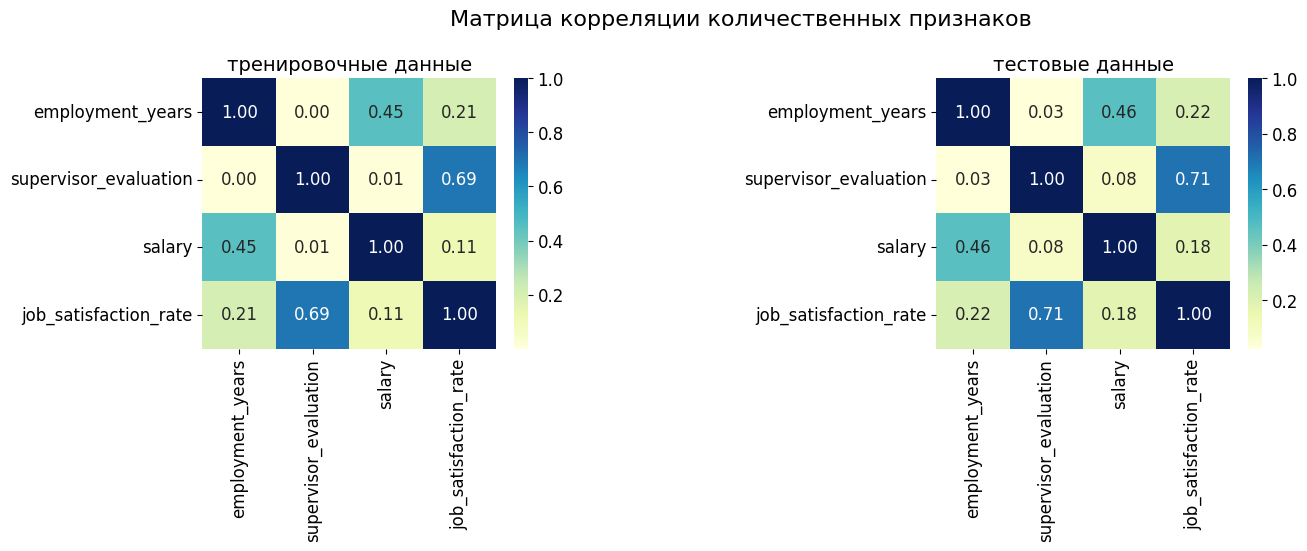

In [27]:
# матрица корреляций
corr_m_train = df_train_jsr.corr()
corr_m_test = df_test_features_jsr.join(df_test_target_jsr).corr()

fig, ax = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('Матрица корреляции количественных признаков')
fig.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=1)
# визуализируем ее сиборном
sns.heatmap(corr_m_train, annot=True, cmap='YlGnBu', fmt=".2f", ax=ax[0])
sns.heatmap(corr_m_test, annot=True, cmap='YlGnBu', fmt=".2f", ax=ax[1])

ax[0].set_title('тренировочные данные')
ax[1].set_title('тестовые данные')
plt.show()

* Среди количественных признаков не наблюдается мультиколлинеарности.


Проверим остальные признаки на мультиколлинеарность, для этого построим матрицу корреляции кол-ных и кат-ых характеристик.

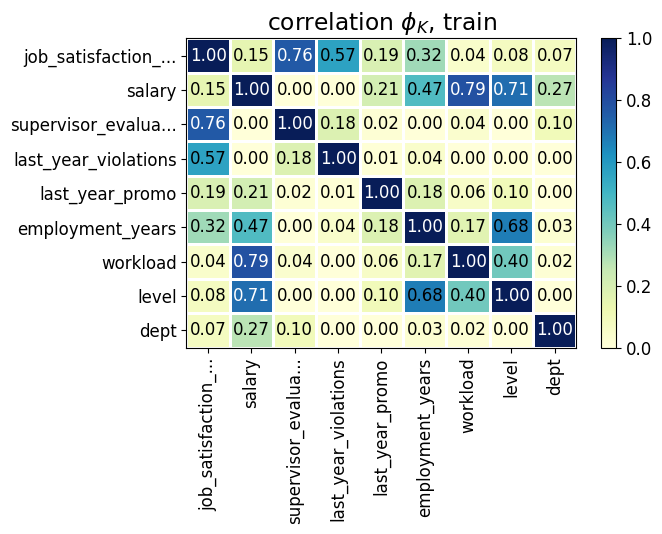

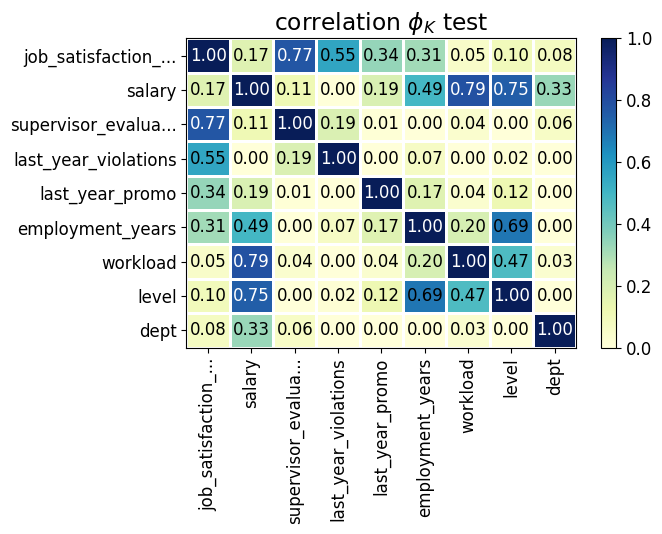

In [28]:
phik_overview_train = df_train_jsr.phik_matrix(interval_cols=interval_cols)
phik_overview_test = df_test_features_jsr.join(df_test_target_jsr).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview_train.values,
    x_labels=phik_overview_train.columns,
    y_labels=phik_overview_train.index,
    vmin=0, vmax=1, 
    color_map='YlGnBu',
    title=r'correlation $\phi_K$, train',
    fontsize_factor=1.2,
    figsize=(7,5.5)
)
plot_correlation_matrix(
    phik_overview_test.values,
    x_labels=phik_overview_test.columns,
    y_labels=phik_overview_test.index,
    vmin=0, vmax=1, 
    color_map='YlGnBu',
    title=r'correlation $\phi_K$ test',
    fontsize_factor=1.2,
    figsize=(7,5.5)
)

По коэффициентам матрицы корреляции `ɸk` можно сказать, что между входными признами нет мультиколлинеарности признаком.
Это касается и тренировочной, и тестовой выборок.

#### Выводы

1. В среднем сотрудники работают в компании 3.8 лет.


2. Средняя заработная плата сотрудников составляет 34 457.4 рубля.


3. Средний показатель удовлетворенности сотрудников работой в компании равен 0.53.


4. 37% работников связана с отделом продаж, меньше всего сотрудников работает/работало в отделе hr 12%.


5. Всего 10% работников занимает/занимало высокие должности в компании, тогда как джунов и мидлов поровну.


6. Чуть больше половины работников имеют среднюю загруженность на работе, 19% сильно нагружены, а 30% сотрудников имеют низкую загруженность.


7. Мультиколлинеарности между входными признаками нет.

---

### Подготовка данных

#### Подготовка тренировочной и тестовой выборок

In [29]:
# разделим датафрейм 'df_train_jst' на целевой и входные признаки
X_train_jsr = df_train_jsr.drop('job_satisfaction_rate', axis=1)

In [30]:
y_train_jsr = df_train_jsr.job_satisfaction_rate

# объявим тестовые выборки
X_test_jsr = df_test_features_jsr.copy()
y_test_jsr = df_test_target_jsr.job_satisfaction_rate

In [31]:
# выведем первые строки тренировочной выборки
display(X_train_jsr.head(), y_train_jsr.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600
101057,sales,junior,low,1,no,yes,4,19200
101074,sales,junior,medium,2,no,no,2,20400
101081,sales,middle,low,2,no,no,4,28800
101129,technology,junior,medium,1,no,no,4,34800


id
100954    0.60
101057    0.45
101074    0.36
101081    0.66
101129    0.71
Name: job_satisfaction_rate, dtype: float64

#### Кодирование и масштабирование данных

In [32]:
# список колонок для кодирования OneHotEncoder() для линейных моделей
ohe_columns_lr = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
# список колонок для кодирования OneHotEncoder() для нелинейных моделей
ohe_columns = ['dept']
# список колонок для кодирования OrdinalEncoder() для нелинейных моделей
ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
# список колонок для масштабирования
num_columns = ['employment_years','supervisor_evaluation', 'salary']

In [33]:
# создаём пайплайн для подготовки признаков из списка ohe_columns:
# заполнение пропусков SimpleImputer() + кдирование OneHotEncoder()
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [34]:
# создаём пайплайн для подготовки признаков из списка ord_columns:
# заполнение пропусков SimpleImputer() + кодирование OrdinalEncoder() + заполнение пропусков SimpleImputer()
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'senior'],
                ['low', 'medium', 'hight'],
                ['no', 'yes'],
                ['yes', 'no']
            ],
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [35]:
# создаём общий пайплайн для подготовки данных для нелинейных моделей
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

# создаём общий пайплайн для подготовки данных линейных моделей
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_lr),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

---

### Обучение модели

In [36]:
# итоговый пайплайн: подготовка данных и модель
pipe_final_reg = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('regressor', DummyRegressor())
    ]
)
pipe_final_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'hight'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['yes',
                                                                                               'no']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('regressor', DummyRegressor())])

In [37]:
# создадим список словарей для подбора модели МО и ее гиперпараметров
param_grid_reg = [    
#     словарь для модели DecisionTreeRegressor()
    {
        'regressor': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'regressor__max_depth': range(5,11),
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели KNeighborsRegressor()
    {
        'regressor': [KNeighborsRegressor(weights='distance')],
        'regressor__n_neighbors': range(5,11),
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели SVR()
    {
        'regressor': [SVR(kernel='rbf')],
        'regressor__C': [0.1, 0.5, 1, 5, 10],
        'preprocessor': [data_preprocessor, data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели SVR()
    {
        'regressor': [SVR(kernel='linear')],
        'regressor__C': [0.1, 0.5, 1, 5, 10],
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели LinearRegression()
    {
        'regressor': [LinearRegression()],
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [38]:
# скорер для GridSearchCV()
smape_score = make_scorer(calculate_smape, greater_is_better=False)

In [39]:
# найдем лучшую модель с помощью GridSearchCV()
grid_search_reg = GridSearchCV(
#     передаем итоговый пайплайн, как estimator
    pipe_final_reg, 
#     в качестве параметров - список словарей моделей с гиперпараметрами для подбора
    param_grid_reg, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1
)

# обучим на тренировочных данных
grid_search_reg.fit(X_train_jsr, y_train_jsr)

# выведем пайплайн лучшей модели
print('Лучшая модель и её параметры:')
display(grid_search_reg.best_estimator_)
print(f'Метрика SMAPE модели на кросс-валидации: {np.abs(grid_search_reg.best_score_):.2f}%')

Лучшая модель и её параметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('regressor', SVR(C=5))])

Метрика SMAPE модели на кросс-валидации: 14.64%


In [40]:
# проверим точность модели на тестовой выборке
y_test_jsr_preds = grid_search_reg.predict(X_test_jsr)
print(f'Метрика SMAPE модели на тестовой выборке: {calculate_smape(y_test_jsr, y_test_jsr_preds):.2f}%')

Метрика SMAPE модели на тестовой выборке: 13.72%


Метрика SMAPE на тестовой выборке соответствует критерию успеха модели.

Сравним эту метрику с результатом метрики случайного предсказывания целевого признака.

In [41]:
pipe_final_reg.fit(X_train_jsr, y_train_jsr)

# проверим точность модели на тестовой выборке
y_test_jsr_dummy_pred = pipe_final_reg.predict(X_test_jsr)
f'Метрика SMAPE случайной модели на тестовой выборке: {calculate_smape(y_test_jsr, y_test_jsr_dummy_pred):.2f}%'

'Метрика SMAPE случайной модели на тестовой выборке: 38.26%'

Метрика лучшей модели почти в 3 раза меньше метрики модели случайного предсказывания.

#### Анализ важности признаков

In [42]:
# сохраним в переменной лучшую модель регрессор
best_regressor = grid_search_reg.best_estimator_.named_steps['regressor']
# сохраним в переменной пайплайн подготовки данных для модели регрессора
best_reg_preprocessor = grid_search_reg.best_estimator_.named_steps['preprocessor']

# сохраним назкания колонок после подготовки данных
# удали префиксы, что появляются на этапах подготовки данных
features_names_jsr = [remove_prefixes(name) for name in best_reg_preprocessor.get_feature_names_out()]

# сохраним трансформированные транировочные данные
X_test_jst_transformed = pd.DataFrame(best_reg_preprocessor.transform(X_test_jsr), columns=features_names_jsr)

In [43]:
# сократим кол-во образцов
X_jst = shap.sample(X_test_jst_transformed, nsamples=200, random_state=RANDOM_STATE)
# объявим explainer_jst
explainer_jst = shap.KernelExplainer(best_regressor.predict, X_jst)
# применим explainer_jst к тестовым данным
shap_values_jst = explainer_jst(X_jst)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

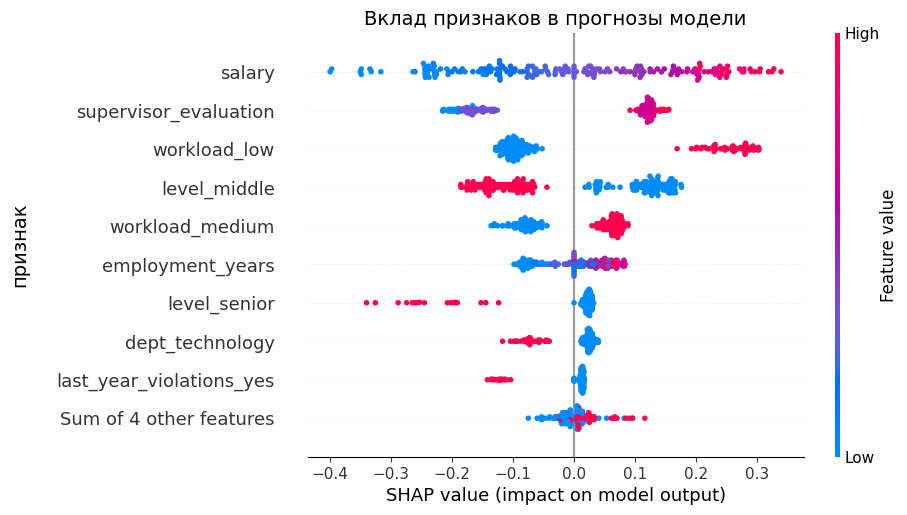

In [44]:
# визуализирум полученные значения
shap.plots.beeswarm(shap_values_jst, show=False)
plt.title('Вклад признаков в прогнозы модели')
plt.ylabel('признак\n', fontsize=14);

1. Для модели наибольшее значение в предсказании имеет признак `заработная плата сотрудника`, чем она выше, тем выше уровень удовлетворенности сотрудника.


2. На втором месте по значимости `оценка качества работы сотрудника`, здесь таже, как с з/п, связь прямая.


3. Сотрудники с низким уровнем загруженности оценивают свою удовлетворенность работой выше остальных.


4. Работники со средним уровнем занимаемой должности оценивают удовлетворенность работой ниже остальных.


5. Чем выше `длительность работы в компании`, тем выше оценка удовлетворенностью работой.

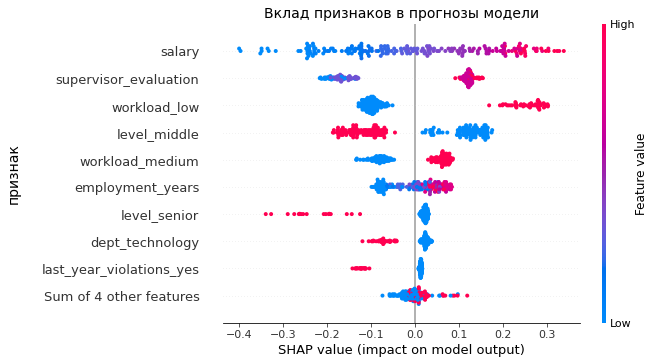

---

### Выводы

1. Лучше всего с предсказанием уровня удовлетворенности работой сотрудников справилась модель `SVR(kernel='rbf', C=5)` с кодированием категориальных данных только `OneHotEncoder()`. Метрика SMAPE модели на тренировочных данных равна 13.72%.


2. Наиболее значимым признаком является признак `salary`, чем он выше, тем выше значения уровня удовлетворенности сотрудников.

---
---

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [45]:
pth1 = '/datasets/train_quit.csv'
pth1_1 = 'https://example.ru/train_quit.csv'

pth2 = '/datasets/test_features.csv'
pth2_1 = 'https://example.ru/test_features.csv'

pth3 = '/datasets/test_target_quit.csv'
pth3_1 = 'https://example.ru/test_target_quit.csv'

server_pth = [pth1, pth2, pth3]
local_pth = [pth1_1, pth2_1, pth3_1]

df_train_quit = pd.DataFrame
df_test_features_quit = pd.DataFrame
df_test_target_quit = pd.DataFrame

datas = [df_train_quit, df_test_features_quit, df_test_target_quit]

In [46]:
for i, el in enumerate(datas):
    try:
        datas[i] = pd.read_csv(local_pth[i], index_col='id')
    except:
        datas[i] = pd.read_csv(server_pth[i], index_col='id')

In [47]:
# выведем первые строки таблиц
for el in datas:
    display(el.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [48]:
df_train_quit = datas[0].sort_index()
df_test_features_quit = datas[1].sort_index()
df_test_target_quit = datas[2].sort_index()

---

### Предобработка данных

#### train_quit

In [49]:
# проверим наличие явных дубликатов
f'Кол-во явных дубликатов: {df_train_quit.duplicated().sum()}'

'Кол-во явных дубликатов: 1413'

In [50]:
df_train_quit.drop_duplicates(inplace=True)

In [51]:
# выведем информацию по таблице
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   2587 non-null   object
 1   level                  2587 non-null   object
 2   workload               2587 non-null   object
 3   employment_years       2587 non-null   int64 
 4   last_year_promo        2587 non-null   object
 5   last_year_violations   2587 non-null   object
 6   supervisor_evaluation  2587 non-null   int64 
 7   salary                 2587 non-null   int64 
 8   quit                   2587 non-null   object
dtypes: int64(3), object(6)
memory usage: 202.1+ KB


Пропусков данных в тренировочной выборке не наблюдается.

Посмотрим уникальные строковые значения колонок.

In [52]:
# уникальные значения колонок типа 'object'
for col in list(df_train_quit.select_dtypes(include='object').columns):
    print(col, df_train_quit[col].unique())
    print()

dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']

level ['junior' 'middle' 'sinior']

workload ['medium' 'high' 'low']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']

quit ['yes' 'no']



Неявных дубликатов не наблюдается, значения те же, что и предыдущих датафреймах.

In [53]:
df_train_quit.replace('sinior', 'senior', inplace=True)

Изменим тип данных колонок на 'category'.

In [54]:
# изменение типа данных колонок
for col in list(df_train_quit.select_dtypes(include='object').columns):
    df_train_quit[col] = df_train_quit[col].astype('category')

In [55]:
# выведем информацию по таблице
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 100222 to 999915
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   dept                   2587 non-null   category
 1   level                  2587 non-null   category
 2   workload               2587 non-null   category
 3   employment_years       2587 non-null   int64   
 4   last_year_promo        2587 non-null   category
 5   last_year_violations   2587 non-null   category
 6   supervisor_evaluation  2587 non-null   int64   
 7   salary                 2587 non-null   int64   
 8   quit                   2587 non-null   category
dtypes: category(6), int64(3)
memory usage: 96.8 KB


#### test_features_quit

In [56]:
df_test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [57]:
# для каждой колонки выведем название и уникальные значения
for col in list(df_test_features_quit.select_dtypes(include='object').columns):
    print(col, df_test_features_quit[col].unique())
    print()

dept ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']

level ['junior' 'middle' 'sinior' nan]

workload ['low' 'high' 'medium' ' ']

last_year_promo ['no' 'yes']

last_year_violations ['no' 'yes']



In [58]:
df_test_features_quit.replace({'sinior': 'senior', ' ': np.nan}, inplace=True)

df_test_features_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


В тестовой выборке имеются пропущенные значения, которые будут заполнены в пайплайне во время подготовки данных.

#### test_features_quit

In [59]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


#### Проверка на пересечение данных

In [60]:
# проверим на пересечение данных тренировочную и тестовую выборки
count=0
for el in df_train_quit.index: 
    count += int(el in df_test_features_quit.index)
f'Кол-во пересечений: {count}'

'Кол-во пересечений: 0'

In [61]:
# проверим на пересечение данных тренировочную и тестовую выборки
count=0
for el in df_train_quit.index: 
    count += int(el in df_test_features_quit.index)
f'Кол-во пересечений: {count}'

'Кол-во пересечений: 0'

In [62]:
# проверим соответствуюл ли 'id' работников в df_X_test и df_test_features
f'Кол-во соответствующих строк с  "id" работников: {(df_test_features_jsr.index == df_test_features_quit.index).sum()}'

'Кол-во соответствующих строк с  "id" работников: 2000'

#### Выводы

1. Были удалены дублирующиеся в тренировочной выборке данные.


2. В тестовых данных обнаружены пропуски, которые необходимо заполнить во время подготовки данных.


3. Данные тренировочной и тестовой выборок не пересекаются.

---

### Исследовательский анализ данных

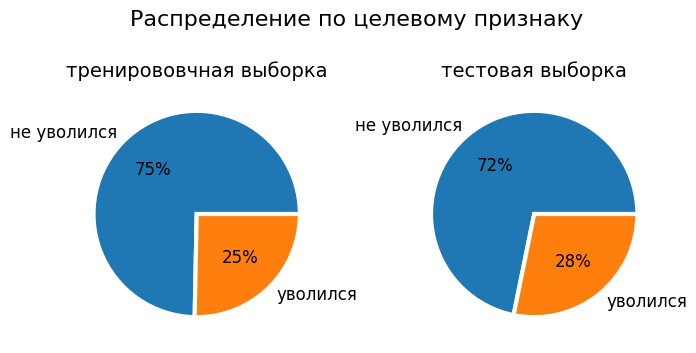

In [63]:
fig, ax = plt.subplots(1,2, figsize=(7,4))
fig.suptitle('Распределение по целевому признаку')
fig.tight_layout(pad=1.5)
l_dict = {'no': "не уволился", 'yes': "уволился"}

s = df_train_quit.quit.value_counts()
l = [l_dict.get(x) for x in df_train_quit.quit.value_counts().index]
ax[0].pie(s, labels=l,
          autopct='%1.0f%%',
          wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
          pctdistance=.6, labeldistance=1.1)
ax[0].set_title('тренирововчная выборка')

s = df_test_target_quit.quit.value_counts()
l = [l_dict.get(x) for x in df_test_target_quit.quit.value_counts().index]
ax[1].pie(s, labels=l,
          autopct='%1.0f%%',
          wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
          pctdistance=.6, labeldistance=1.1);
ax[1].set_title('тестовая выборка');


Доля уволившихся сотрудников сотавляет 25% всех сотрудников тренировочной выборке и 28% в тестовой.

Составим портрет увольняющегося сотрудника.

#### Количественные данные

1. Рассмотрим распределения дискретных характеристик в записимости от целевого признака (`уволился`, `не уволился`).

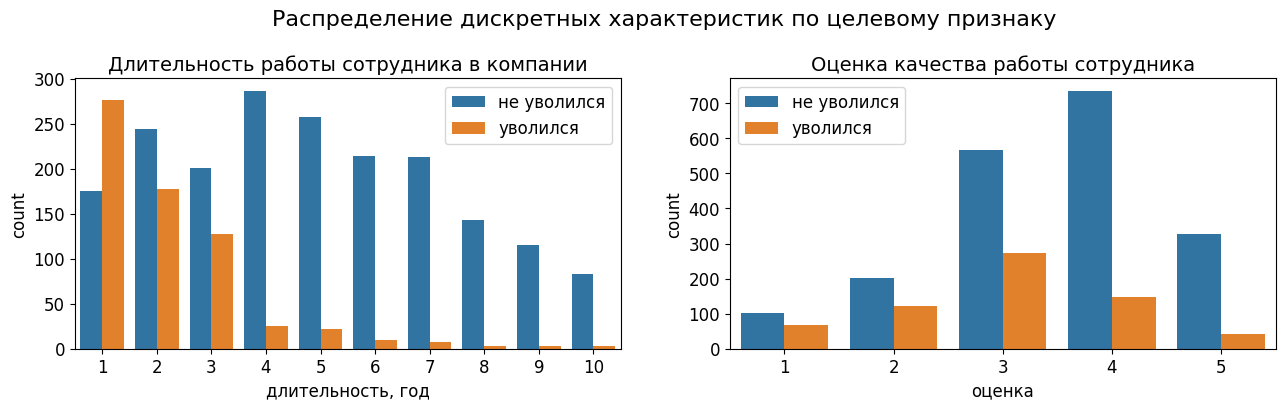

In [64]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Распределение дискретных характеристик по целевому признаку')
fig.tight_layout(pad=1.5)
plt.subplots_adjust(wspace=.2)
for i, col in enumerate(discrete_cols):
    sns.countplot(data=df_train_quit, x=col, ax=ax[i], hue='quit')
    ax[i].legend(['не уволился', "уволился"])
ax[0].set_title('Длительность работы сотрудника в компании')
ax[0].set_xlabel('длительность, год')
ax[1].set_title('Оценка качества работы сотрудника')
ax[1].set_xlabel('оценка');

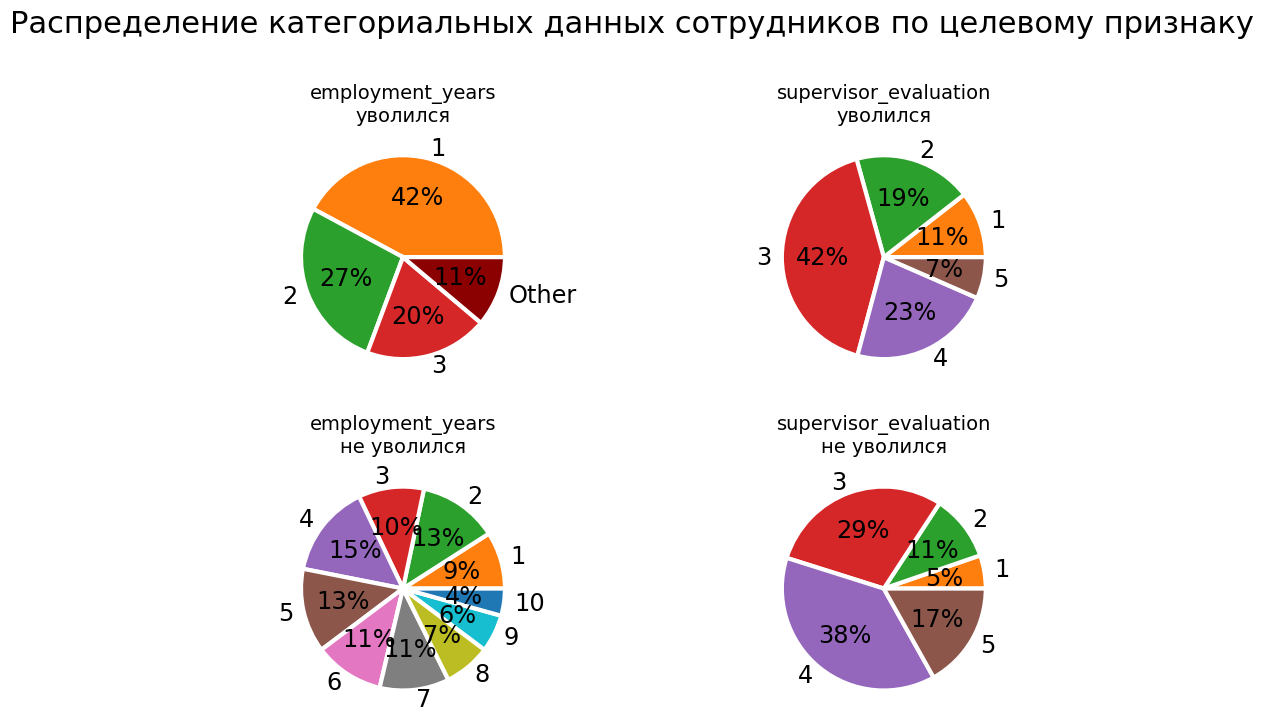

In [65]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
fig.suptitle(f'Распределение категориальных данных сотрудников по целевому признаку', fontsize=22)
fig.tight_layout(pad=3)
plt.subplots_adjust(wspace=.3, hspace=.3)
colours = {1:'C1', 2:'C2', 3:'C3', 4:'C4', 5:'C5', 6:'C6', 7:'C7', 8:'C8', 9:'C9', 10:'C10', 'Other':'darkred'}

for i, col in enumerate(discrete_cols):
#     уволившиеся сотрудники
    if col == 'employment_years':
        quit = df_train_quit.query('quit == "yes"').pivot_table(index=col, values='quit', aggfunc='count').nlargest(3, 'quit')
        quit = quit.reset_index()
        quit = quit.append(
            {
                'employment_years': 'Other',
                'quit': df_train_quit.query('quit == "yes"')['quit'].count() - quit['quit'].sum()
            },
            ignore_index= True)
    else:
        quit = df_train_quit.query('quit == "yes"').pivot_table(index=col, values='quit', aggfunc='count')
        quit = quit.reset_index()
    
#     оставшиеся сотрудники
    stay = df_train_quit.query('quit == "no"').pivot_table(index=col,
                                                           values='quit',
                                                           aggfunc='count')
    stay = stay.reset_index().rename(columns={'quit':'stay'})

    q_lab = quit[col]
    s_lab = stay[col]
    quit.plot(kind='pie',
              y="quit",
              autopct='%1.0f%%',
              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
              textprops={'size': 'x-large'}, 
              labels=q_lab,
              colors=[colours[key] for key in q_lab],
              legend=False, 
              title = f'{col}\nуволился',
              ax=ax[0,i]).set(ylabel='')

    stay.plot(kind='pie',
              y="stay",
              autopct='%1.0f%%',
              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
              textprops={'size': 'x-large'},
              labels=s_lab,
              colors=[colours[key] for key in s_lab],
              legend=False,
              title = f"{col}\nне уволился",
              ax=ax[1,i]).set(ylabel='');

* В основном увольняются сотрудники, что проработали в компании 1-3 года. Сотрудники проработавшие 4 года и более увольняются реже.


* Сотрудники, чья оценка качества работы равна 4 и 5 баллам уволняются реже, чем остальные.

Посмотрим на средние и медианные значения количественных характеристик для уволившихся и неуволившихся сотрудников.

In [66]:
# выведем длительность работы сотрудников в компании
(
    df_train_quit.query('quit == "yes"')['employment_years'].agg(['mean', 'median'])
    .to_frame().rename(columns={'employment_years': 'уволился'})
).join(
    df_train_quit.query('quit == "no"')['employment_years'].agg(['mean', 'median'])
    .to_frame().rename(columns={'employment_years': 'не уволился'})
)

,уволился,не уволился
mean,2.161832,4.908903
median,2.000000,5.000000


In [67]:
# выведем оценку качества работы сотрудников 
(
    df_train_quit.query('quit == "yes"')['supervisor_evaluation'].agg(['mean', 'median'])
    .to_frame().rename(columns={'supervisor_evaluation': 'уволился'})
).join(
    df_train_quit.query('quit == "no"')['supervisor_evaluation'].agg(['mean', 'median'])
    .to_frame().rename(columns={'supervisor_evaluation': 'не уволился'})
)

,уволился,не уволился
mean,2.958779,3.506729
median,3.000000,4.000000


Проведем статистический тест: о сроке работы сотрудников из обеих групп и их оценках качества работы.

In [68]:
# Нулевая гипотеза:
#         Уволившиеся сотрудники работают в компании столько же, что неуволившиеся сотрудники.
# Альтернативная гипотеза:
#         Уволившиеся сотрудники и оставшиеся сотрудники работают в компании разное время.

# 'ttest_ind' для сравнения 2 выборок
# 'equal_var=False' так как выборки могут быть разного размера
results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['employment_years'],
    df_train_quit.query('quit=="no"')['employment_years'],
    equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Уволившиеся сотрудники и неуволившиеся сотрудники работают в компании разное время.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Уволившиеся сотрудники работают в компании столько же, что неуволившиеся сотрудники.')

p-значение: 5.353204804988329e-194
Отвергаем нулевую гипотезу.
    Уволившиеся сотрудники и неуволившиеся сотрудники работают в компании разное время.


In [69]:
# Нулевая гипотеза:
#         Уволившиеся сотрудники работают в компании столько же, что неуволившиеся сотрудники.
# Альтернативная гипотеза:
#         Уволившиеся сотрудники работают в компании меньше, чем неуволившиеся сотрудники.

# 'ttest_ind' для сравнения 2 выборок
# 'equal_var=False' так как выборки могут быть разного размера
# alternative='less' - альернативная гипотеза sample_1 < sample_2
results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['employment_years'],
    df_train_quit.query('quit=="no"')['employment_years'],
    equal_var=False,
    alternative='less')
print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Уволившиеся сотрудники работают в компании МЕНЬШЕ, чем неуволившиеся сотрудники.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Уволившиеся сотрудники работают в компании столько же, что неуволившиеся сотрудники')

p-значение: 2.6766024024941644e-194
Отвергаем нулевую гипотезу.
    Уволившиеся сотрудники работают в компании МЕНЬШЕ, чем неуволившиеся сотрудники.


Таким образом, *уволившиеся сотрудники, действительно, в среднем работают в компании меньше, чем неуволившиеся сотрудники*.

In [70]:
# Нулевая гипотеза:
#         Оценки качества работы уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Оценки качества работы уволившихся и оставшихся работников НЕ равны.

results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['supervisor_evaluation'],
    df_train_quit.query('quit=="no"')['supervisor_evaluation'],
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Оценки качества работы уволившихся и оставшихся работников НЕ равны.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Оценки качества работы уволившихся и оставшихся работников равны.')

p-значение: 3.134290519619018e-29
Отвергаем нулевую гипотезу.
    Оценки качества работы уволившихся и оставшихся работников НЕ равны.


In [71]:
# Нулевая гипотеза:
#         Оценки качества работы уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Оценки качества работы уволившихся сотрудников меньше, чем оценка оставшихся работников.

results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['supervisor_evaluation'],
    df_train_quit.query('quit=="no"')['supervisor_evaluation'],
    equal_var=False,
    alternative='less')
print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Оценки качества работы уволившихся сотрудников МЕНЬШЕ, чем оценка оставшихся работников.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Оценки качества работы уволившихся и оставшихся работников равны.')

p-значение: 1.567145259809509e-29
Отвергаем нулевую гипотезу.
    Оценки качества работы уволившихся сотрудников МЕНЬШЕ, чем оценка оставшихся работников.


*Руководители в среднем оценивали качество работы уволившихся сотрудников ниже, чем неуволившихся сотрудников*.

2. Рассмотрим распределение заработной платы по целевому признаку

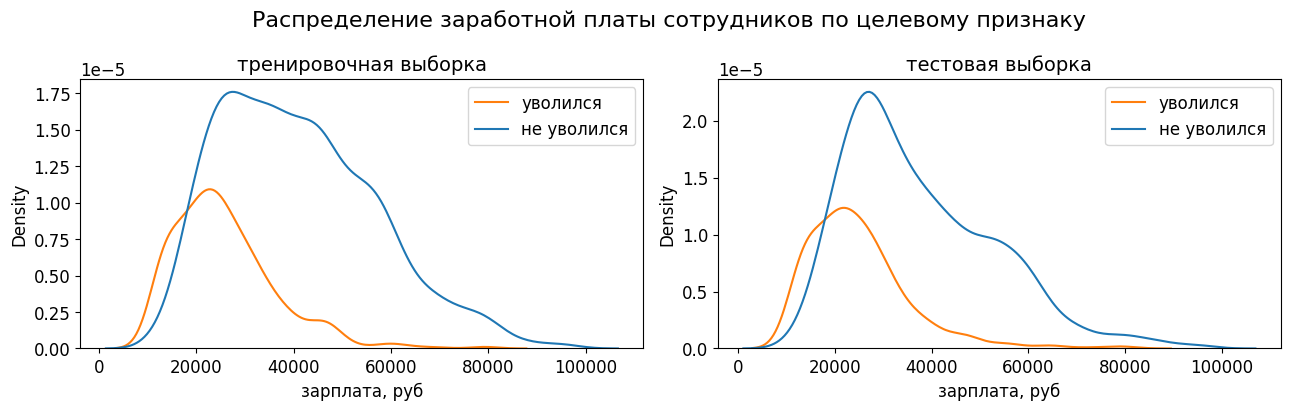

In [72]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Распределение заработной платы сотрудников по целевому признаку')
fig.tight_layout(pad=1.5)
sns.kdeplot(data=df_train_quit, x='salary', hue='quit', ax=ax[0])
ax[0].set_title('тренировочная выборка')

sns.kdeplot(data=df_test_features_quit.join(df_test_target_quit), x='salary', hue='quit', ax=ax[1])
ax[1].set_title('тестовая выборка')
for i in range(0,2):
    ax[i].set_xlabel('зарплата, руб')
    ax[i].legend(["уволился", "не уволился"])
plt.show()

Средняя заработная плата уволившихся сотрудников ниже, чем у оставшихся в компании.

In [73]:
# выведем заработную плату сотрудников 
(
    df_train_quit.query('quit == "yes"')['salary'].agg(['mean', 'median'])
    .to_frame().rename(columns={'salary': 'уволился'})
).join(
    df_train_quit.query('quit == "no"')['salary'].agg(['mean', 'median'])
    .to_frame().rename(columns={'salary': 'не уволился'})
)

,уволился,не уволился
mean,25767.938931,40952.173913
median,24000.000000,39000.000000


Проверим гипотезы о заработной плате сотрудников из разных категорий.

In [74]:
# Нулевая гипотеза:
#         Заработные плата уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Заработная плата уволившихся сотрудников НЕ равна заработной плате оставшихся сотрудников.

results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['salary'],
    df_train_quit.query('quit=="no"')['salary'],
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Заработная плата уволившихся сотрудников НЕ равна заработной плате оставшихся сотрудников.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Заработные плата уволившихся и оставшихся работников равны.')

p-значение: 1.0210409046956176e-139
Отвергаем нулевую гипотезу.
    Заработная плата уволившихся сотрудников НЕ равна заработной плате оставшихся сотрудников.


In [75]:
# Нулевая гипотеза:
#         Заработные плата уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Заработная плата уволившихся сотрудников меньше заработной платы оставшихся сотрудников.

results = st.ttest_ind(
    df_train_quit.query('quit=="yes"')['salary'],
    df_train_quit.query('quit=="no"')['salary'],
    equal_var=False,
    alternative='less')
print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Заработная плата уволившихся сотрудников МЕНЬШЕ заработной платы оставшихся сотрудников.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Заработные плата уволившихся и оставшихся работников равны.')

p-значение: 5.105204523478088e-140
Отвергаем нулевую гипотезу.
    Заработная плата уволившихся сотрудников МЕНЬШЕ заработной платы оставшихся сотрудников.


Действительно, результаты статисчтического теста показывают, что *средняя заработная плата сотрудников, что уволились из комании, ниже, чем средняя заработная плата сотрудников, что остались работать в компании*.

#### Категориальные данные

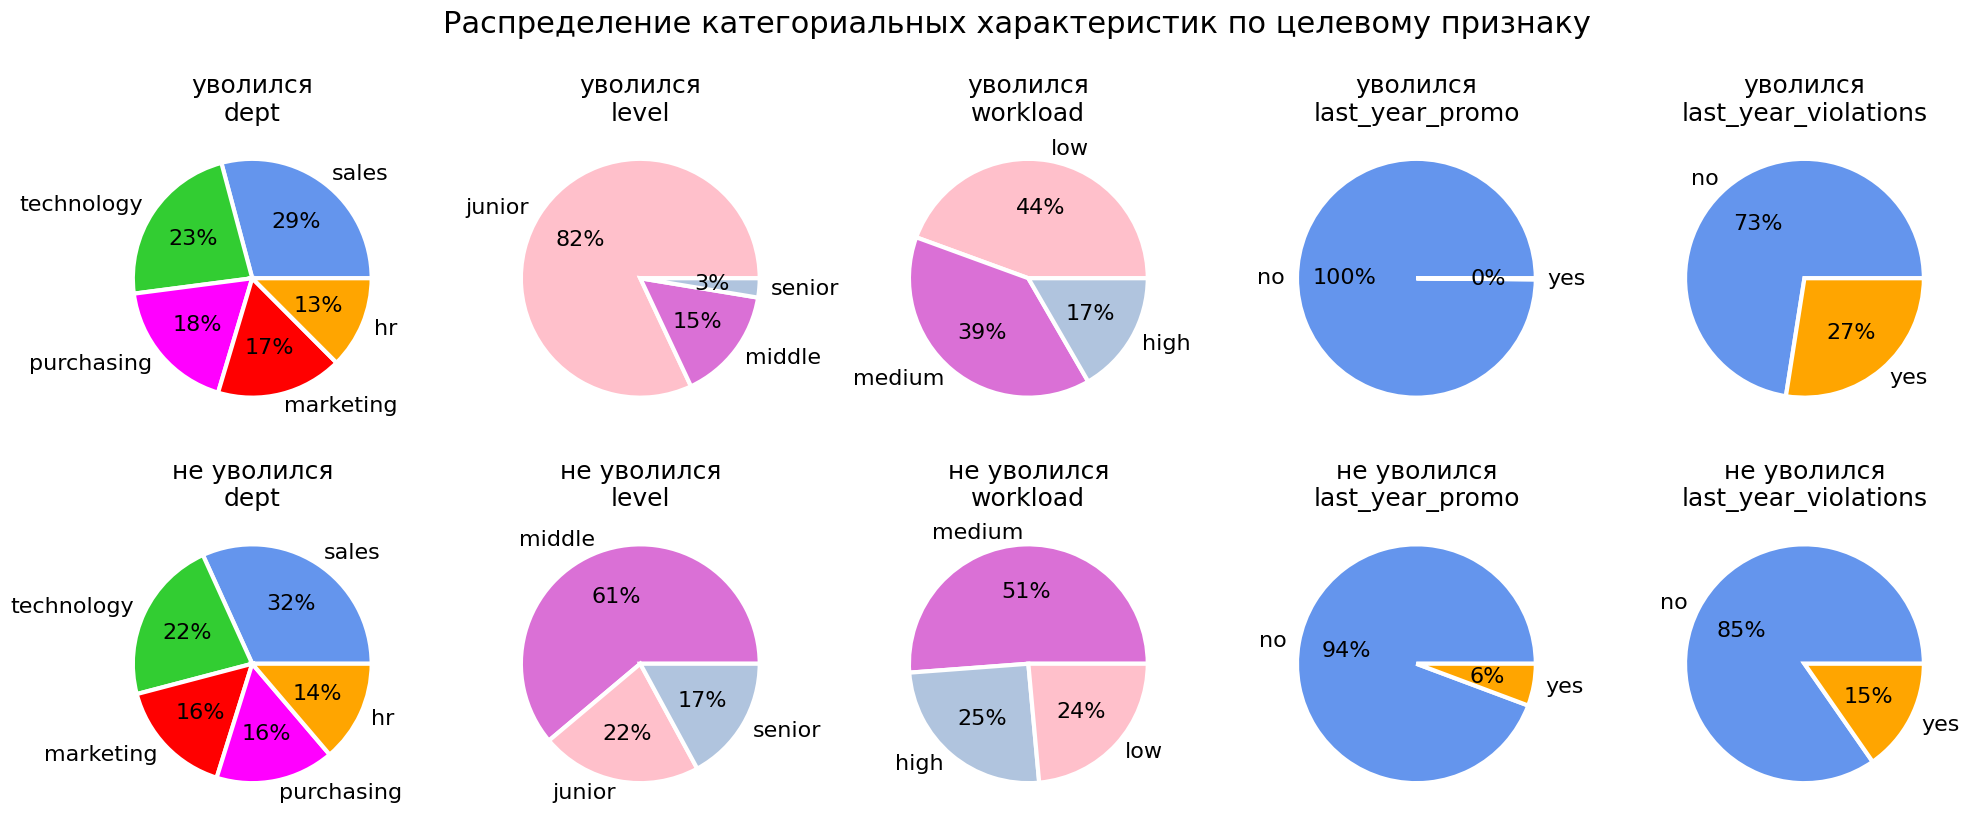

In [76]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20,9))
fig.suptitle(f'Распределение категориальных характеристик по целевому признаку', fontsize=22)
fig.tight_layout(pad=3)
plt.subplots_adjust(wspace=.3)
colours = {
    'sales':'cornflowerblue',
    'technology':'LimeGreen',
    'purchasing':'Fuchsia',
    'marketing':'red',
    'hr':'orange',
    'junior':'pink',
    'middle':'orchid',
    'senior':'lightsteelblue',
    'low':'pink',
    'medium':'orchid',
    'high':'lightsteelblue',
    'no':'cornflowerblue',
    'yes':'orange'}
for i, col in enumerate(categorial_cols):
    l = df_train_quit.query('quit == "yes"')[col].value_counts().index
    s = df_train_quit.query('quit == "yes"')[col].value_counts()
#     пирог
    ax[0,i].pie(s, labels=l,
                autopct='%1.0f%%',
                textprops={'fontsize':16},
                colors=[colours[key] for key in l],
                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                pctdistance=.6, labeldistance=1.1)
    ax[0,i].set_title(f'уволился\n{col}', fontsize=18)
    
    
    
    l = df_train_quit.query('quit != "yes"')[col].value_counts().index
    s = df_train_quit.query('quit != "yes"')[col].value_counts()
#     пирог
    ax[1,i].pie(s, labels=l,
                autopct='%1.0f%%',
                textprops={'fontsize':16},
                colors=[colours[key] for key in l],
                wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                pctdistance=.6, labeldistance=1.1)
    ax[1,i].set_title(f'не уволился\n{col}', fontsize=18)
plt.show()

1. Распределение уволившихся и оставшихся сотрудников по отделам почти одинаково.


2. Среди уволившихся сотрудников больше джунов.


3. Среди уволившихся сотрудников больше работников низким уровнем загруженности.


4. За последний год уволившиеся сотрудники не получали повышения. 


5. Среди уволившихся сотрудников чаще встречаются те, кто нарушил трудовой договор за последний год.

####  Связь уровеня удовлетворённости сотрудника и  уволнения сотрудника

In [77]:
# создадим датафрейм для тестовой выборки с колонками удовлетвороенностью работой и увольнением из фирмы
test_jsr_quit = df_test_target_quit.join(df_test_target_jsr)
# выведем первые строки
test_jsr_quit.head()

,quit,job_satisfaction_rate
id,,
100298,no,0.80
100480,no,0.84
100503,no,0.79
100610,no,0.75
100692,no,0.69


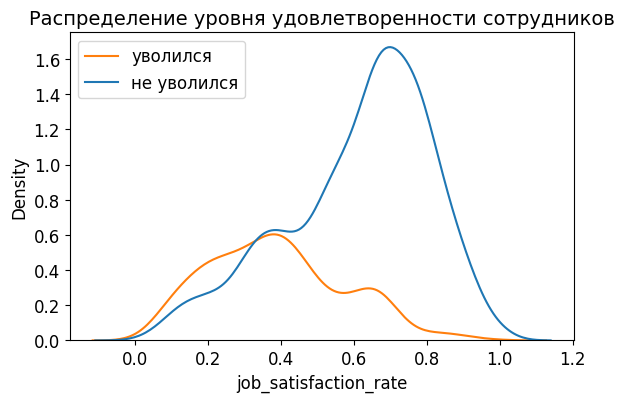

In [78]:
plt.figure(figsize=(6.5,4))
sns.kdeplot(data=test_jsr_quit, x='job_satisfaction_rate', hue='quit')
plt.title('Распределение уровня удовлетворенности сотрудников')
plt.legend(['уволился', 'не уволился']);

Среди уволившихся сотрудников уровень удовлетворенностью работой в компании ниже, чем у оставшихся сотрудников.

Посмотрим статистику уровня удовлетворенности по тому, уволился ли сотрудник.

In [79]:
# выведем удовлетворенность сотрудников 
(
    test_jsr_quit.query('quit == "yes"').agg(['mean', 'median']).rename(columns={'job_satisfaction_rate': 'уволился'})
).join(
    test_jsr_quit.query('quit == "no"').agg(['mean', 'median']).rename(columns={'job_satisfaction_rate': 'не уволился'})
)

,уволился,не уволился
mean,0.387713,0.61204
median,0.370000,0.66000


Судя по всему уволившиеся сотрудники в меньшей степени удовлетворены работой в компании, чем неуволившиеся сотрудники.

Проверим эту гипотезу с помощью статистических тестов.

In [80]:
# Нулевая гипотеза:
#         Удовлетворенность работой в компании уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Удовлетворенность работой в компании уволившихся сотрудников НЕ равна удовлетворенности работой оставшихся сотрудников.

results = st.ttest_ind(
    test_jsr_quit.query('quit=="yes"')['job_satisfaction_rate'],
    test_jsr_quit.query('quit=="no"')['job_satisfaction_rate'],
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Удовлетворенность работой в компании уволившихся сотрудников НЕ равна удовлетворенности работой оставшихся сотрудников.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Удовлетворенность работой в компании уволившихся и оставшихся работников равны.')

p-значение: 2.7708628031539788e-101
Отвергаем нулевую гипотезу.
    Удовлетворенность работой в компании уволившихся сотрудников НЕ равна удовлетворенности работой оставшихся сотрудников.


In [81]:
# Нулевая гипотеза:
#         Удовлетворенность работой в компании уволившихся и оставшихся работников равны.
# Альтернативная гипотеза:
#         Удовлетворенность работой в компании уволившихся сотрудников МЕНЬШЕ удовлетворенности работой оставшихся сотрудников.

results = st.ttest_ind(
    test_jsr_quit.query('quit=="yes"')['job_satisfaction_rate'],
    test_jsr_quit.query('quit=="no"')['job_satisfaction_rate'],
    equal_var=False,
    alternative='less')
print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу.\n\
    Удовлетворенность работой в компании уволившихся сотрудников МЕНЬШЕ удовлетворенности работой оставшихся сотрудников.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.\n\
    Удовлетворенность работой в компании уволившихся и оставшихся работников равны.')

p-значение: 1.3854314015769894e-101
Отвергаем нулевую гипотезу.
    Удовлетворенность работой в компании уволившихся сотрудников МЕНЬШЕ удовлетворенности работой оставшихся сотрудников.


Действительно, *средняя удовлетворенность работой уволившихся сотрудников меньше, чем удовлетворенность работой сотрудников, что не уволились*.

#### Выводы

Портрет среднестатистического уволившегося сотрудника:

Сотрудник, проработавший в компании 2.2 года на джуниорской должности с низким уровнем загруженности. Средняя заработная плата уволившегося сотрудника равна 25 767.9 рублям.

---

#### Добавление нового признака

In [82]:
# предскажем уровень удовлетворенности сотрудников для тренировочной выборки
# добавим предсказанные значения в датафрейм 'df_train_quit'
df_train_quit['job_satisfaction_rate'] = grid_search_reg.best_estimator_.predict(df_train_quit.drop('quit', axis=1)).round(2)
# выведем первые строки
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.42
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.37
100469,marketing,junior,medium,1,no,no,4,28800,no,0.65
100601,technology,middle,high,4,no,no,4,68400,no,0.77
100858,sales,junior,medium,2,no,no,4,25200,yes,0.79


In [83]:
# добавим предсказанный уровень удовлетворенности сотрудников для тестовой выборки
df_test_features_quit['job_satisfaction_rate'] = y_test_jsr_preds.round(2)
# выведем первые строки
df_test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.86
100480,marketing,junior,low,4,no,no,4,16800,0.76
100503,purchasing,middle,high,5,no,no,4,55200,0.70
100610,sales,middle,medium,5,no,no,4,43200,0.83
100692,sales,middle,high,6,no,no,4,48000,0.70


#### Корреляционный анализ данных

Корреляционный анализ количественных данных уже проводился при решении первой задачи.

Проверим матрицу корреляции `ɸk` с учетов целевого признака - `увольнение сотрудника`.

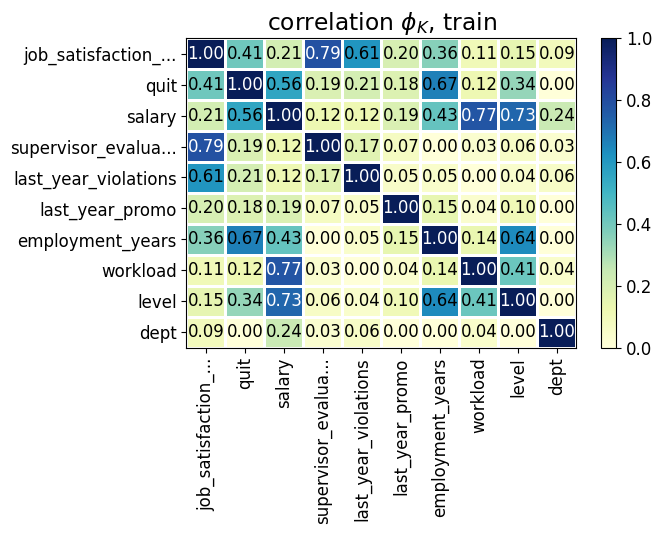

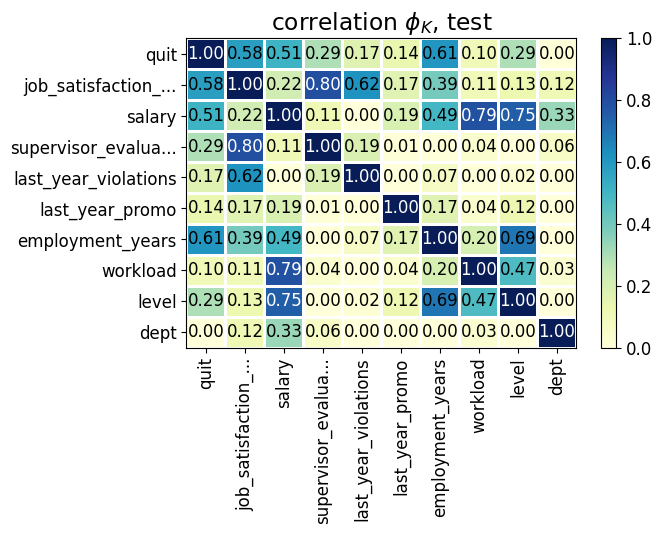

In [84]:
phik_overview_train = df_train_quit.phik_matrix(interval_cols=interval_cols)
phik_overview_test = df_test_features_quit.join(df_test_target_quit).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview_train.values,
    x_labels=phik_overview_train.columns,
    y_labels=phik_overview_train.index,
    vmin=0, vmax=1, 
    color_map='YlGnBu',
    title=r'correlation $\phi_K$, train',
    fontsize_factor=1.2,
    figsize=(7,5.5)
) 

plot_correlation_matrix(
    phik_overview_test.values,
    x_labels=phik_overview_test.columns,
    y_labels=phik_overview_test.index,
    vmin=0, vmax=1, 
    color_map='YlGnBu',
    title=r'correlation $\phi_K$, test',
    fontsize_factor=1.2,
    figsize=(7,5.5)
) 

Мультиколлинеарности признаков не наблюдается.

---

### Подготовка данных

#### Разделение данных

In [85]:
# разделим датафрейм 'df_train' на целевой и входные признаки
X_train_quit = df_train_quit.drop('quit', axis=1)
y_train_quit = df_train_quit['quit']

# объявим тестовые выборки
X_test_quit = df_test_features_quit.copy()
y_test_quit = df_test_target_quit['quit']

In [86]:
# выведем первые строки тренировочной выборки
display(X_train_quit.head(), y_train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,0.42
100459,purchasing,junior,medium,3,no,no,3,21600,0.37
100469,marketing,junior,medium,1,no,no,4,28800,0.65
100601,technology,middle,high,4,no,no,4,68400,0.77
100858,sales,junior,medium,2,no,no,4,25200,0.79


id
100222    yes
100459    yes
100469     no
100601     no
100858    yes
Name: quit, dtype: category
Categories (2, object): ['no', 'yes']

In [87]:
# объявим LabelEncoder для кодирования целевого признака
le = LabelEncoder()
# обучим на тренировочных данных
le.fit(y_train_quit)
# сохраним кодированные данные для тренировочной и тестовой выборок
y_train_quit = le.transform(y_train_quit)
y_test_quit = le.transform(y_test_quit)

#### Кодирование и масштабирование данных

In [88]:
# выведем список количественных характеристик
num_columns

['employment_years', 'supervisor_evaluation', 'salary']

In [89]:
# добавим 'job_satisfaction_rate' в список
num_columns.append('job_satisfaction_rate')

num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [90]:
# занова объявим общий пайплайн для нелинейных моделей
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

# и для линейных
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_lr),
        ('num', 'passthrough', num_columns)
    ],
    remainder='passthrough'
)

---

### Обучение модели

In [91]:
# итоговый пайплайн: подготовка данных и модель
pipe_final_clf = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('classifier', DummyClassifier(random_state=RANDOM_STATE))
    ]
)
pipe_final_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'hight'],
                                                                                              ['no',
                                                                                               'yes'],
                                                                                              ['yes',
                                                                                               'no']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),...
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('num', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('classifier', DummyClassifier(random_state=42))])

In [92]:
# создадим список словарей для подбора модели МО и ее гиперпараметров
param_grid_clf = [    
#     словарь для модели DecisionTreeClassifier()
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': range(5,11),
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },    
    
#     словарь для модели SVC()
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True)],
        'classifier__C': [0.1,0.5,1,5],
        'classifier__gamma': ['scale', 'auto'],
        'preprocessor': [data_preprocessor],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели KNeighborsClassifier() 
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(5,11),
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
#     словарь для модели LogisticRegression()
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, penalty='l1', solver='saga', max_iter=200)],
        'classifier__C': [0.1,0.5,1,5],
        'preprocessor': [data_preprocessor_lr],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [93]:
# найдем лучшую модель с помощью GridSearchCV()
grid_search_clf = GridSearchCV(
#     передаем итоговый пайплайн, как estimator
    pipe_final_clf, 
#     в качестве параметров - список словарей моделей с гиперпараметрами для подбора
    param_grid_clf, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search_clf.fit(X_test_quit, y_test_quit)

# выведем пайплайн лучшей модели
print('Лучшая модель и её параметры:')
display(grid_search_clf.best_estimator_)
print(f'Метрика ROC-AUC лучшей модели на кросс-валидации: {grid_search_clf.best_score_:.3f}')

Лучшая модель и её параметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary',
                                                   'job_satisfaction_rate'])])),
                ('classifier',
                 LogisticRegression(C=0.5, max_iter=200, penalty='l1',
                                    random_state=42, solver='saga'))])

Метрика ROC-AUC лучшей модели на кросс-валидации: 0.919


In [94]:
# проверим точность модели на тестовой выборке
y_test_quit_preds = grid_search_clf.predict_proba(X_test_quit)
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test_quit, y_test_quit_preds[:,1]):.3f}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.921


На тестовых данных получился хороший показатель метрики. Сравним его с метрикой для модели случайно предсказывающей значения.

In [95]:
pipe_final_clf.fit(X_train_quit, y_train_quit)

# проверим точность модели на тестовой выборке
y_test_quit_dummy_proba = pipe_final_clf.predict_proba(X_test_quit)[:,1]
f'Метрика ROC-AUC случайной модели на тестовой выборке: {roc_auc_score(y_test_quit, y_test_quit_dummy_proba):.3f}'

'Метрика ROC-AUC случайной модели на тестовой выборке: 0.500'

Метрика лучшей модели на тестовых данных на 0.421 лучше метрики модели случайных предсказаний.

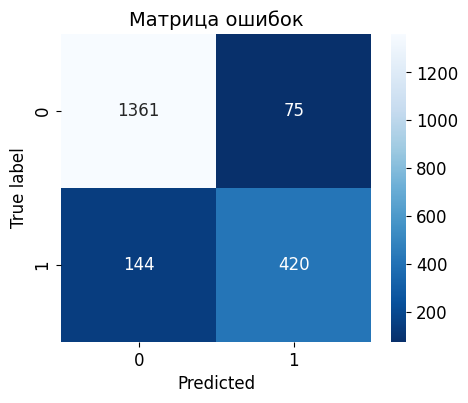

In [96]:
plt.figure(figsize=(5,4))
# посчитаем матрицу
cm = confusion_matrix(y_test_quit, grid_search_clf.predict(X_test_quit))
# выведем результат
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Матрица ошибок');

Модель предсказывает 15% (73 из 493) ложноположительных увольнений и не предсказывает 26% (144 из 564) случаев увольнения.

#### Анализ важности признаков

In [97]:
# сохраним лучшую модель
best_classifier = grid_search_clf.best_estimator_.named_steps['classifier']
# сохраним пайплайн подготовки данных для лучшей модели
best_clf_preprocessor = grid_search_clf.best_estimator_.named_steps['preprocessor']
# сохраним названия колонок после кодирования
features_names_quit = [remove_prefixes(name) for name in best_clf_preprocessor.get_feature_names_out()]
# трансформируем тестовую выборку
X_test_quit_transformed = pd.DataFrame(best_clf_preprocessor.transform(X_test_quit), columns=features_names_quit)

In [98]:
# объявим explainer_quit
explainer_quit = shap.LinearExplainer(best_classifier, X_test_quit_transformed)
# применим explainer_quit к тестовым данным
shap_values_quit = explainer_quit(X_test_quit_transformed)

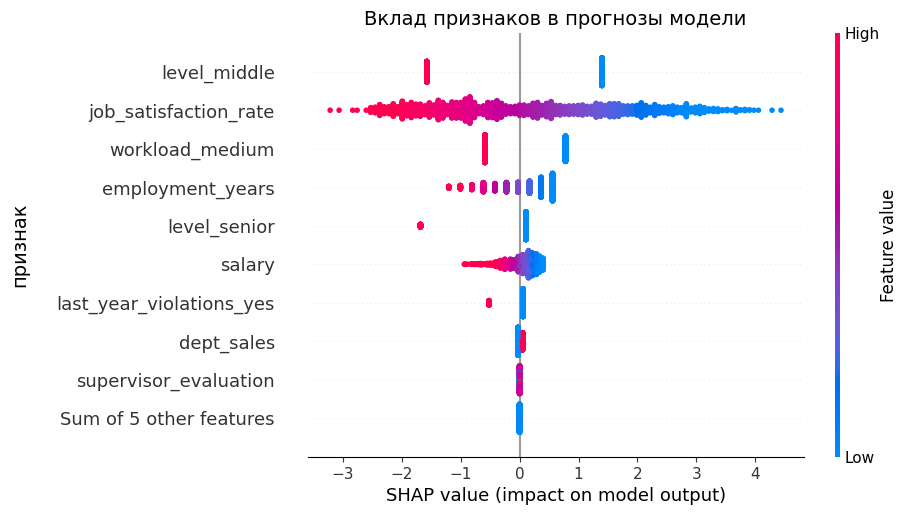

In [99]:
# визуализируем результаты explainer_quit
shap.plots.beeswarm(shap_values_quit, show=False)
plt.title('Вклад признаков в прогнозы модели')
plt.ylabel('признак\n', fontsize=14);

---

### Выводы

1. Лучшей моделью предсказания увольнения сотрудников является модель `LogisticRegression(C=0.5, max_iter=200, penalty='l1', random_state=42, solver='saga')
`. Метрика ROC-AUC лучшей модели на тренировочных данных составила 0.921.


2. Наиболее значимым признаком для модели является `level_middle`: сотрудники на должности мидла с большей вероятностью останутся в компании. Следом идет `уровень удовлетворенности работой`: чем ниже показатель, тем выше шанс увольнения сотрудника.

---
---

## Итоговые выводы

Увольнение сотрудника из компании связано с уровнем его удовлетворенности работой в компании. Проведение опросов среди всех работников слишком энергоемко, поэтому была предложена разработка моделей машинного обучения, которые будут предсказывать удовлетворенность сотрудников работой в компании и предсказывать увольнение сотрудника.

1. Полученные данные были проверены на наличие пропусков и дубликатов. Обнаруженные пропуски данных были устранены.

2. Проведен исследовательский анализ данных:

    * изучено распределение всех данных о сотрудниках;
    * данные были проверены на наличие мультиколлинеарности.

4. На основе данных о сотрудниках была обучена лучшая модель регрессии `SVC`, которая предсказывает уровень удовлетворенности сотрудников с метрикой SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение») равной 13.68%.

    Наиболее значимым признаком для модели является `заработная плата`, чем она выше, тем выше значения уровня удовлетворенности сотрудников.

3. Составлен портрет сотрудника, который с большей вероятностью уволится из компании:

    *Сотрудник, проработавший в компании 1-3 года на джуниорской должности с низким уровнем загруженности. Средняя заработная плата уволившегося сотрудника равна 25 768 рублям.*

5. С учетом предсказанного уровня удовлетворенности работников и фактических данных работников была обучена лучшая модель логистической регрессии `LogisticRegression`, которая предсказывает увольнение сотрудников с точностью 92.1%.

**Рекомендации по снижению уровня увольнений.**

На основе результатов исследовательского анализа данных и изучения портрета уволившегося сотрудника, предлагается:
    
   **1. следить за уровнем удовлетворенности работой сотрудников на младших должностях, устроенных в компании 1-3 года**.


С учетом значимости признака `заработной платы` сотрудника предлагается:

   **2. своевременная индексация уровня заработной платы сотрудников, для сохранения и/или повышения уровня удовлетворенности сотрудников работой**. Возможно повышение сотрудников до средних должностей, так как сотрудники средних должностей увольняются реже сотрудников младших должностей.